# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [1]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 58.2 MB/s eta 0:

In [2]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#run this cell only the first time to create and save the tokenizer and the date
dump = False

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [6]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [7]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 43, 113, 9, 299, 628, 645, 6, 98, 114, 2425, 3]
shuffled sentecen:  [2, 98, 114, 299, 628, 645, 9, 4, 2425, 113, 43, 6, 3]


Let us look at detokenized data:

In [8]:
# i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> the first player to go cannot move and so will lose <end>
shuffled sentence:  <start> so will go cannot move to the lose player first and <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


# Data Augmentation
Since transformers perform better when using large datasets, it's better to apply some data augmentation techniques.

In particular:
1.   Using the remaining part of the wikipedia dataset provide lots of useful data
2.   Splitting longer sentences into two smaller sub-sentences could help the transformers in dealing with the reconstruction of longest ones 

This kind of techniques aim to collect more data for the training phase, without modifying both the test set and the tokenizer.

In [11]:
# Using the other part of the wikipedia dataset in order to collect as much data as possible
# Performing this operation won't change the test set and won't change the tokenizer  
data2 = dataset['train'][20000:]['text']

corpus2 = []

# Split of each piece of text into sentences
for elem in data2:
    corpus2 += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus2))

#add a start and an end token
corpus2 = ['<start> '+s+' <end>' for s in corpus2]

original_data2 = [sen for sen in tokenizer.texts_to_sequences(corpus2) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

corpus dim:  1813443


In [12]:
shuffled_data2 = [random.sample(s[1:-1], len(s) - 2) for s in original_data2]
shuffled_data2 = [[sos] + s + [eos] for s in shuffled_data2]
target_data2 = [s[1:] for s in original_data2]

In [13]:
original_data2[0]

[2, 4, 827, 5, 4, 3384, 2856, 19, 37, 163, 4, 1024, 10, 8901, 3]

In [14]:
x_train += original_data2
c_train += shuffled_data2
y_train += target_data2

In [42]:
# data augmentation 2
# Take all the sentences whose len is >= 16 and divide them in 2 sub-sentences
# This should help the transformer to deal with large sentences, learning how to reconstruct them
actual_len = len(x_train)
for i in range(actual_len):
    x_sen = x_train[i]
    x_sen = x_sen[1:-1]
    if len(x_sen) >= 16:  
        # Only take sentences longer than 16 words (excluding sos and eos) and split them in the middle
        middle_sentence = len(x_sen) // 2
        
        # first and second subpart of the sentence, which will be added as new data in x_train after adding sos and eos
        first_subpart = x_sen[:middle_sentence]
        second_subpart = x_sen[middle_sentence:]
        
        # first and second subpart but shuffled, which will be added as new data in c_train after adding sos and eos
        first_subpart_shuffled = random.sample(first_subpart, len(first_subpart))
        second_subpart_shuffled = random.sample(second_subpart, len(second_subpart))

        # adding sos and eos
        first_subpart_shuffled = [sos] + first_subpart_shuffled + [eos]
        second_subpart_shuffled = [sos] + second_subpart_shuffled + [eos]

        first_subpart = [sos] + first_subpart + [eos]
        second_subpart = [sos] + second_subpart + [eos]

        # appending on x_train
        x_train.append(first_subpart)
        x_train.append(second_subpart)
        
        # appending on c_train
        c_train.append(first_subpart_shuffled)
        c_train.append(second_subpart_shuffled)
        
        # in y_train adding the first and second subpart but shifted by one timestamp
        y_train.append(first_subpart[1:])
        y_train.append(second_subpart[1:])   


Depending from the model you plan to build, you might require padding the input sequence

In [43]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [44]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 641818


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

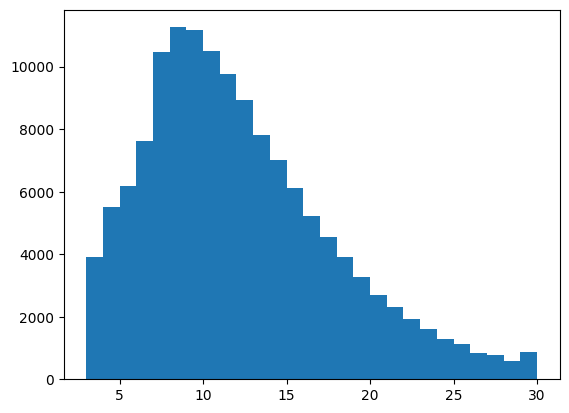

In [46]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [47]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  # modified scoring funciton (division by the max len between the two strings)
  return (match.size/max(len(s),len(p)))

Let's do an example.

In [48]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [49]:
import numpy as np
import tensorflow as tf
import keras.backend as k

# Model
Both the transformer and the learning rate schedule are taken from the [tensorflow example](https://www.tensorflow.org/text/tutorials/transformer) on transformers. 

The following changes have been made:
*   Single embedder for both encoder and decoder
*   Removed positional embedding in the encoder since the indexes of the word in the input sentences are not relevant, because they are shuffled sentences

Digression on other models:

Other approaches have been tried:
* Simple LSTM
* Bidirectional LSTM
* LSTM with a sort of attention mechanism
* Bidirectional LSTM with a sort of attention mechanism

but none of them was able to achieve a good score.

In [50]:
# positional encoding uses a set of sines and cosines at different frequencies
# so nearby elements will have similar position encodings
def positional_encoding(length, depth):
    depth = depth/2
    
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [51]:
# the Positional Embedding look's up a token's embedding vector and adds the position vector
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder#tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=32, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [52]:
# to deal with attention it's better to define a base class which contains the component layers
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()

In [53]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [54]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [55]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [56]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [57]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [58]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = embedder#tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    # self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [59]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [60]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [61]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [62]:
# hyper-parameters of the Model

num_layers = 4
d_model = 160
dff = 512
num_heads = 8
dropout_rate = 0.2

In [63]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10_000,
    target_vocab_size=10_000,
    dropout_rate=dropout_rate)

In [64]:
# CustomSchedule allows to have a learning which is higher in the first part of the training and then decreases
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [65]:
learning_rate = CustomSchedule(d_model)

# using Adam as optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Custom Loss Function

The aim of this custom loss is to create a mask which gives more importance to the first words in the sentence.

The key idea is that if the transformer learns well how to generate the first few words, then it will perform better having the first part of the string correctly generated.

The workflow for the custom loss is the following:
*   a constant value is given, in this case K_VALUE=0.97
*   the mask is created as a boolean vector given by label != 0 (ignoring padding)
*  the sparse categorical crossentropy is computed between the ground truth and the predicted value
*  then the boolean mask is multiplied by a tensor which contains value like K_VALUE**(i)  for i in 1...max_sequence_len, so there is an higher value in the first element and smaller value as we move further in the tensor
*  the mask is computed by multiplying the original boolean mask with the tensor created at the previous step (to ignore padding)
* the loss is computed by multipling the loss computed by the sparse categorical crossentropy with the mask

This function can be customized by changing the K_VALUE and the exponent of the tensor.

Another idea (tested with little worse results) is to create a custom shifting loss function, which starts giving more weights to the first words and then shifts the focus to the other parts of the sequence as learning phase goes on. In order to obtain such a results, I used a callbacks which changes the focus of the loss function based on the epoch number.

# Accuracy Metrics
The accuracy is taken from the tensorflow tutorial and comptues the accuracy between the ground truth and the predicted label by ignoring the padding, to have a more reliable value

In [66]:
K_VALUE = 0.97

def custom_masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    a = tf.cast(tf.range(1,max_sequence_len+1),tf.float32)
    constant_val = tf.constant(K_VALUE)
    final_array = tf.pow(constant_val,a)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred): 
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [67]:
# compiling the model using the custom loss function, the optimizer defined above and the masked accuracy metric
transformer.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [68]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

epochs = 100
batch_size=1024

history = transformer.fit(
    (c_train, x_train),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [es],
    validation_split = 0.1
)

Epoch 1/100
565/565 [==============================] - 344s 525ms/step - loss: 7.2669 - masked_accuracy: 0.1674 - val_loss: 5.3164 - val_masked_accuracy: 0.3095
Epoch 2/100
565/565 [==============================] - 281s 497ms/step - loss: 4.1337 - masked_accuracy: 0.4065 - val_loss: 2.8858 - val_masked_accuracy: 0.5434
Epoch 3/100
565/565 [==============================] - 280s 496ms/step - loss: 2.4715 - masked_accuracy: 0.5749 - val_loss: 1.7634 - val_masked_accuracy: 0.6574
Epoch 4/100
565/565 [==============================] - 270s 477ms/step - loss: 1.6395 - masked_accuracy: 0.6637 - val_loss: 1.2048 - val_masked_accuracy: 0.7297
Epoch 5/100
565/565 [==============================] - 270s 478ms/step - loss: 1.2937 - masked_accuracy: 0.7044 - val_loss: 1.0325 - val_masked_accuracy: 0.7525
Epoch 6/100
565/565 [==============================] - 269s 477ms/step - loss: 1.1332 - masked_accuracy: 0.7269 - val_loss: 0.9188 - val_masked_accuracy: 0.7723
Epoch 7/100
565/565 [=============

In [69]:
# saving weights to save computation and just test
# transformer.save_weights("transformer_data_augmented/transformer")

In [70]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [71]:
# !cp -rf transformer_data_augmented /content/drive/MyDrive/Università/DL/Project/DataAugmentedVersion

In [72]:
# summary of the model
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1600000   
                                                                 
 encoder (Encoder)           multiple                  5553408   
                                                                 
 decoder (Decoder)           multiple                  8847488   
                                                                 
 dense_16 (Dense)            multiple                  1610000   
                                                                 
Total params: 14,410,896
Trainable params: 14,410,896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# transformer.load_weights("transformer_data_augmented/transformer")

# Translator
The aim of this class is to define an object which, when called, takes in input a batch of shuffled sentences and gives as results the output of the transformer.



In [73]:
import keras.backend as K

class Translator(tf.Module):
    def __init__(self, transformer, tokenizer):
        self.transformer = transformer
        self.tokenizer = tokenizer
              
    def __call__(self, input_sentences, max_length=max_sequence_len):
        # batch size is the number of sentences passed in input
        batch_size = K.int_shape(input_sentences)[0]
        encoder_input = input_sentences
        # all the decoded sentences will start with the index of the token <start>
        decoded_indexes = [[self.tokenizer.word_index['<start>']] for _ in range(batch_size)]

        # allowed words allows to filter the predictions of the model, restricting the choose of the predictions to the only word that were in the original shuffled sentences
        allowed_words = [ [word for word in sentence if word not in [sos, eos, 0]] for sentence in encoder_input]

        for i in range(1, max_length):
            # preparing the input of the transformer
            decoder_input = tf.convert_to_tensor(decoded_indexes)
            # running the transformer on the partially decoded sentences
            predictions = np.array(self.transformer((np.array(encoder_input), np.array(decoder_input))))
            # slicing the prediction on the last tokens which are the ones we are interested in 
            predictions = predictions[:, -1, :]

            for j in range(batch_size):
                # if there are no more allowed words for a specific sentence, concatenate the eos token
                if len(allowed_words[j]) == 0:
                    best_token = eos
                # otherwise, filter the predicions on just the tokens remaining in the array allowed_words and keeps the best prediction for those as new token to be added to the sentence
                else:
                    filtered_predictions = predictions[j, np.array(allowed_words[j])]
                    best_index = np.argmax(filtered_predictions)
                    best_token = allowed_words[j][best_index]

                    # removing the tokens sampled from the allowed_words
                    del allowed_words[j][best_index]
                # appending the best token to the decoded sentence
                decoded_indexes[j].append(best_token)
        return decoded_indexes

In [74]:
# helper function to remove useless tokens and additional spaces from a string
def process(sentence):
    return sentence.replace('<start>', '').replace('<pad>', '').replace('<end>', '').strip()

In [75]:
# defining the translator
translator = Translator(transformer, tokenizer)

In [76]:
# testing the transformer with the translator object on 3k samples
# using batches of 500 samples allows the visualization of intermediate results and partial score as testing proceeds

batch_size = 500
total = 3000

sc = 0
for i in range(total//batch_size):
    # taking the corresponding batch from the shuffled and target sentences
    shuffled_sentences = c_test[i*batch_size :(i+1)*batch_size]
    original_sentences = y_test[i*batch_size :(i+1)*batch_size]
    # obtaining the results of the translator 
    translated = translator(shuffled_sentences)
    for j in range(batch_size):
        # processing the several sentences
        single_shuffled = process(tokenizer.sequences_to_texts([shuffled_sentences[j]])[0])

        single_translated = tokenizer.sequences_to_texts([translated[j]])[0]
        single_translated = single_translated.split("<end>")[0]
        single_translated = process(single_translated)
        
        single_original = process(tokenizer.sequences_to_texts([original_sentences[j]])[0])
        
        # updating the score
        sc = sc + score(single_original, single_translated)
    print(f"Computed: {i+1}; Score: {sc/((i+1)*batch_size)}")
    
# final score
sc = sc/total
print("Total score:", sc)

Computed: 1; Score: 0.5875923621772859
Computed: 2; Score: 0.605948240158856
Computed: 3; Score: 0.598907024723789
Computed: 4; Score: 0.592806493301154
Computed: 5; Score: 0.5872395224311262
Computed: 6; Score: 0.5923474967205714
Total score: 0.5923474967205714


## Beam Search Algorithm
Another useful optimization consist in using the Beam Search algorithm to generate the output sentence.

The following code is an implementation of the Beam Search for decoding sentences. The idea is to keep track of the best K candidates for each sentence, where K is the beam size. At each step, the best K candidates are selected and the next word is predicted for each of them. Then, the K best candidates are selected and the process is repeated until the end of the sentence is reached.

In [77]:
# inputs:
# - originals: list of original sentences
# - model: the trained model
# - tokenizer: the tokenizer used to encode the sentences
# - max_length: the maximum length of the sentences
# - beam_width: the number of candidates to keep at each step of the beam search
def beam_search_decode_sentences(originals, model, tokenizer, max_length=32, beam_width=3):
    # Initialize the decoder inputs with a start token
    batch_size = len(originals)
    decoder_inputs = np.zeros((batch_size, max_length))
    decoder_inputs[:, 0] = sos

    # Initialize the beam search candidates
    candidate_lists = [[{'sequence': decoder_input, 'score': 1.0}] for decoder_input in decoder_inputs]

    # Perform beam search decoding
    # At each step, the beam search algorithm finds the best candidates
    for i in range(1, max_length):

        # Packing the inputs for the decoder
        packed_candidates = []
        packed_originals = []
        # the packing_indices are used to keep track of which candidate belongs to which original sentence
        packing_indices = []
        
        for sentence_index, (original, candidate_list) in enumerate(zip(originals, candidate_lists)):
            for candidate_index, candidate in enumerate(candidate_list):
                packed_candidates.append(candidate['sequence'])
                packed_originals.append(original)
                packing_indices.append((sentence_index, candidate_index))
            
        packed_candidates = np.array(packed_candidates)
        packed_originals = np.array(packed_originals)

        # Get the predictions for this set of inputs
        predictions = model.predict((packed_originals, packed_candidates), verbose=False)

        # Get the top predictions for each candidate
        predicted_indices = np.argsort(predictions[:, i-1, :], axis=-1)#[:, -beam_width:]

        new_candidate_lists = [list() for _ in range(len(candidate_lists))]

        # For each candidate, add the top predictions to the list of candidates
        # by filtering out the ones that are not allowed (same reasoning as in the translator)
        for packed_index, (sentence_index, candidate_index) in enumerate(packing_indices):
            candidate = candidate_lists[sentence_index][candidate_index]

            allowed = list([x for x in originals[sentence_index] if x not in [0, sos, eos]])
            for word in candidate['sequence']:
                try:
                    allowed.remove(word)
                except:
                    pass
            allowed = np.unique(np.array(allowed))
            relevant_indices = predicted_indices[packed_index]
            relevant_indices = relevant_indices[np.isin(relevant_indices, allowed)]
            relevant_indices = relevant_indices[-beam_width:]

            # If there are no more allowed words, add an eos
            if len(relevant_indices) == 0:
                new_sequence = np.copy(candidate['sequence'])
                new_sequence[i] = eos
                new_score = candidate['score']
                new_candidate_lists[sentence_index].append({'sequence': new_sequence, 'score': new_score})
            else:
                # Add the top predictions to the list of candidates
                for m in range(min(len(relevant_indices), beam_width)):
                    new_sequence = np.copy(candidate['sequence'])
                    chosen_word = relevant_indices[m]
                    new_sequence[i] = chosen_word
                    new_score = candidate['score'] * predictions[packed_index, i-1, chosen_word]

                    new_candidate_lists[sentence_index].append({'sequence': new_sequence, 'score': new_score})

        # Sort the candidates by score
        sorted_new_candidate_lists = [sorted(new_candidate_list, key=lambda x: x['score'], reverse=True) for new_candidate_list in new_candidate_lists]
        
        # Keep only the top candidates
        candidate_lists = [candidate_list[:beam_width] for candidate_list in sorted_new_candidate_lists]

    # Select the best candidate as the output sequence
    best_candidates = [candidate_list[0]['sequence'] for candidate_list in candidate_lists]
    output_sentences = [''] * batch_size
    for j in range(batch_size):
        for i in range(1, max_length):
            predicted_index = int(best_candidates[j][i])
            predicted_word = tokenizer.index_word[predicted_index]

            if predicted_word == '<end>':
                break

            output_sentences[j] += predicted_word + ' '
    # Return the output sentences 
    return [output_sentence.strip() for output_sentence in output_sentences]

In [78]:
# testint the beam search on 3k samples with a beam width of 4
# using batches of 250 samples allows the visualization of intermediate results and partial score as testing proceeds

batch_size = 250
total = 3000

all_scores = []
for i in range(total//batch_size):
    shuffled_sentences = c_test[i*batch_size:(i+1)*batch_size]
    original_sentences = y_test[i*batch_size:(i+1)*batch_size]
    translated_sentences = beam_search_decode_sentences(np.array(shuffled_sentences), transformer, tokenizer, beam_width=4)


    processed_shuffled = [process(tokenizer.sequences_to_texts([shuffled_sentence])[0]) for shuffled_sentence in shuffled_sentences]

    translated_sentences = [translated_sentence.split("<end>")[0] for translated_sentence in translated_sentences]
    translated_sentences = [process(translated_sentence) for translated_sentence in translated_sentences]
    
    processed_originals = [process(tokenizer.sequences_to_texts([original_sentence])[0]) for original_sentence in original_sentences]
    
    all_scores += [score(single_original, single_translated) for single_original, single_translated in zip(processed_originals, translated_sentences)]
    print(f"Computed: {len(all_scores)}; Score: {np.mean(all_scores)}")


Computed: 250; Score: 0.5969412690813549
Computed: 500; Score: 0.6021966634283522
Computed: 750; Score: 0.6164446986404143
Computed: 1000; Score: 0.622399580095514
Computed: 1250; Score: 0.6184924543419494
Computed: 1500; Score: 0.6146871525629856
Computed: 1750; Score: 0.6067906248124834
Computed: 2000; Score: 0.6074176653296844
Computed: 2250; Score: 0.6048158154171558
Computed: 2500; Score: 0.602389833481145
Computed: 2750; Score: 0.602505215443995
Computed: 3000; Score: 0.6053393596679355


As can be seen from the results, there are slightly better results using the Beam Search algorithm, but the difference is not so big.

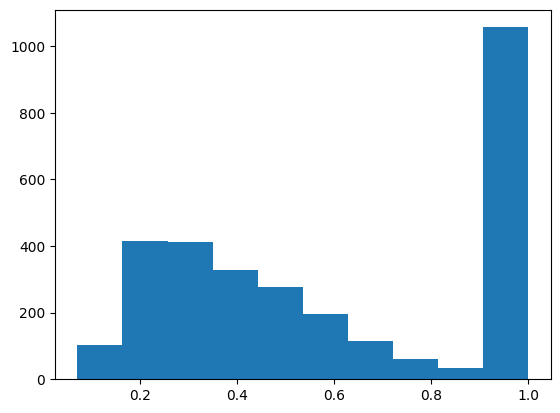

In [79]:
# distribution of all scores from the beam search
plt.hist(all_scores, bins=10)
plt.show()